# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

In [1]:
# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
import statsmodels.api as sm

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
# local or gdrive
path_source = 'local'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  #env_path = '/content/gdrive/MyDrive/.env'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'

In [12]:
# load full dataset
df = pd.read_parquet(os.path.join(data_path, 'joined_dataset/joined_open_schools_only_10-10-22.parquet'))

# join fake med data
df = pd.merge(df, 
  pd.read_parquet(os.path.join(data_path, '../medical/fake_medical_data.parquet')), 
  on=['school_zip', 'year_month'], how='left')

In [14]:
df

,year,cdscode,school_county,school_zip,school_open_date,school_closed_date,school_lat,school_lon,school_wspd,school_elevation_m,year_month,total_population,total_population_male,total_population_female,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,pop_under19_male,pop_under19_female,total_pop_under19,pm25,point_source_lat,point_source_lon,ps_elevation_m,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wind_lat,ps_wind_lon,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,new_year,open_close_dates_valid,Taxable Year,Zip Code,CA_AGI_per_returns,Total Tax Liability,school_county_v2,school_region_name,nearby_point_source_count,open_dates_valid,blood_cancer,type1_diabetes,vasculitis,respiratory
0,2010.0,20102070109728,Madera,93610,2005-08-16,2014-06-30,37.115210,-120.266030,1.531352,70.84,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968,2010-01-01,1,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1,0.000783,0.000710,0.000248,0.000254
1,2010.0,20102072030187,Madera,93610,2001-01-22,2014-06-30,37.115210,-120.266030,1.531352,70.84,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,1873.525780181077,-55.29643968357893,NaN,NaN,1.531352,102.528057,102.528057,157.824497,157.824497,1.531352,157.824497,0.073968,2010-01-01,1,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1,0.000783,0.000710,0.000248,0.000254
2,2010.0,20651930000000,Madera,93610,1990-01-01,2025-01-01,37.122449,-120.264870,1.531352,72.77,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2358.38241919395,-37.54028477906731,NaN,NaN,1.531352,102.528057,102.528057,140.068342,140.068342,1.531352,140.068342,0.233189,2010-01-01,0,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,0.0,1,0.000783,0.000710,0.000248,0.000254
3,2010.0,20651930113076,Madera,93610,2007-08-21,2025-01-01,37.131113,-120.242025,1.531352,77.12,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2892.9075458251764,11.831222108044384,NaN,NaN,1.531352,102.528057,102.528057,90.696835,90.696835,1.531352,90.696835,0.987838,2010-01-01,2,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,0.0,1,0.000783,0.000710,0.000248,0.000254
4,2010.0,20651936023907,Madera,93610,1980-07-01,2025-01-01,37.115243,-120.267770,1.531352,70.66,2010-04-01,23833.0,8280.0,15553.0,1439.0,694.0,745.0,1485.0,729.0,756.0,1407.0,740.0,667.0,1473.0,753.0,720.0,2916.000,2888.0,5804.0,7.736047,37.1056,-120.2487,73.3,2.0127727,2004.5665433091058,-57.72695665034661,NaN,NaN,1.531352,102.528057,102.528057,160.255014,160.255014,1.531352,160.255014,0.058794,2010-01-01,2,2010.0,93610,14375.028223,2905021.0,Madera,Northern San Joaquin Valley,1.0,1,0.000783,0.000710,0.000248,0.000254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471547,2016.0,31669443138500,Placer,96161,1980-07-01,2025-01-01,39.324762,-120.214355,0.168952,1794.66,2016-06-01,18255.0,9580.0,8675.

# Data Clean

In [22]:
# fix some datatypes
num_vars = ['angle_to_school', 'ps_elevation_m', 'pm25', 'point_source_pm25_tpy', 
            'dist_school_to_ps_m', 'angle_to_school']

for var in num_vars:
  df[var] = df[var].astype(float)

# filter out na pm2.5 values (133,261 of them)
df = df[~df['pm25'].isna()]

# just mean impute missing populations (1,584 filled in)
df['pop_under19_male'] = df['pop_under19_male'].fillna(df['pop_under19_male'].mean())
df['pop_under19_female'] = df['pop_under19_female'].fillna(df['pop_under19_female'].mean())

Aggregate data to month/zip level

In [29]:
# maybe not all of these should use 'mean', but doing it this way for now. 
mean_vars = ['school_wspd', 'school_elevation_m', 'ps_elevation_m', 'pop_under19_male', 
             'pop_under19_female', 'pm25', 'point_source_pm25_tpy', 'dist_school_to_ps_m', 
             'angle_to_school', 'ps_wspd_merge', 'school_wdir_wrt_0N', 'ps_wdir_wrt_0N', 
             'school_wind_alignment', 'ps_wind_alignment', 'avg_wind_speed', 
             'avg_wind_alignment', 'avg_wind_alignment_cosine', 
             'blood_cancer', 'type1_diabetes', 'vasculitis', 'respiratory'
             ]
mean_dict = {var:(var, 'mean') for var in mean_vars}

df_grp = df\
  .groupby(['year_month', 'school_county_v2', 'school_region_name', 'school_zip'])\
  .agg(**mean_dict)\
  .reset_index()

df_grp.head(3)

,year_month,school_county_v2,school_region_name,school_zip,school_wspd,school_elevation_m,ps_elevation_m,pop_under19_male,pop_under19_female,pm25,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0N,ps_wdir_wrt_0N,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,blood_cancer,type1_diabetes,vasculitis,respiratory
0,2000-01-01,Alameda,San Francisco Bay Area,94501,1.006650,6.142667,3.793333,6855.0,6497.0,14.600000,5.258067,1717.410608,-33.389362,0.628877,63.227197,68.462249,140.776564,137.445167,0.817763,139.110866,0.337179,0.000976,0.000449,0.000156,0.001018
1,2000-01-01,Alameda,San Francisco Bay Area,94502,1.006650,4.655000,4.210000,1859.0,1845.0,14.880000,9.449277,3018.878458,-139.679287,0.491505,63.227197,70.365905,157.093516,149.954808,0.749077,153.524162,0.113934,0.001111,0.000463,0.000234,0.001151
2,2000-01-01,Alameda,San Francisco Bay Area,94536,0.737964,16.450000,18.311875,8895.0,8391.0,15.858333,3.311320,2247.646116,-27.814214,0.737964,48.730571,48.730571,100.214299,100.214299,0.737964,100.214299,0.844719,0.000990,0.000037,0.000168,0.000901


# EDA 

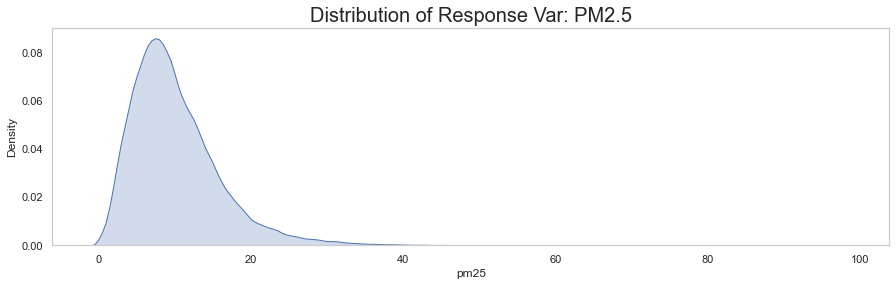

In [30]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_grp, x="pm25", bw_adjust=.8, fill=True).set_title("Distribution of Response Var: PM2.5", size=20)
print('')

# Aim 2 Regression

# Aim 3 Regression